In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import kstest, wasserstein_distance
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
from scipy.signal import welch, coherence
import warnings
warnings.filterwarnings('ignore')


In [21]:


n_features = 32   # EEG channels (we got rid of 8)
n_labels = 4      # Valence, Arousal, Dominance, Liking
latent_dim = 64   # size of random noise vector

# ----------- the Generator -----------
class Generator(nn.Module):
    def __init__(self, latent_dim, n_labels, n_features):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + n_labels, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, n_features),   # output EEG signal
        )
        
    def forward(self, z, labels):  #we take z ==random noise
        x = torch.cat([z, labels], dim=1)  # concat noise + labels
        return self.model(x)
#here since we have one single value for each channel we dont have any sequential or complex data 

# ----------- Discriminator -----------
class Discriminator(nn.Module):
    def __init__(self, n_features, n_labels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_features + n_labels, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        x = torch.cat([x, labels], dim=1)  # we concat EEG + labels
        return self.model(x)


In [22]:
#our models
G = Generator(latent_dim, n_labels, n_features)
D = Discriminator(n_features, n_labels)


criterion = nn.BCELoss()  #fake or real == binary classes
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [23]:


X = np.array(notime_data)  
y = np.array(notime_labels)

# we normalize

batch_size = 32
epochs = 200

for epoch in range(epochs):
    for i in range(0, len(X), batch_size):
        real_X = torch.tensor(X, dtype=torch.float32)
        real_y = torch.tensor(y, dtype=torch.float32)
        batch_size_curr = real_X.size(0)

        # our labesls
        valid = torch.ones(batch_size_curr, 1)
        fake = torch.zeros(batch_size_curr, 1)

        # ---- train the generator ----
        optimizer_G.zero_grad()
        z = torch.randn(batch_size_curr, latent_dim)  # noise
        gen_X = G(z, real_y)  
        validity = D(gen_X, real_y)
        g_loss = criterion(validity, valid)
        g_loss.backward()
        optimizer_G.step()

        # ---- train the discriminator ----
        optimizer_D.zero_grad()
        real_pred = D(real_X, real_y)
        fake_pred = D(gen_X.detach(), real_y)
        real_loss = criterion(real_pred, valid)
        fake_loss = criterion(fake_pred, fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch [{epoch+1}/{epochs}]  D_loss: {d_loss.item():.4f}  G_loss: {g_loss.item():.4f}")


Epoch [1/200]  D_loss: 0.6916  G_loss: 0.6980
Epoch [2/200]  D_loss: 0.6882  G_loss: 0.6952
Epoch [3/200]  D_loss: 0.6941  G_loss: 0.7107
Epoch [4/200]  D_loss: 0.6825  G_loss: 0.6919
Epoch [5/200]  D_loss: 0.6845  G_loss: 0.7123
Epoch [6/200]  D_loss: 0.6757  G_loss: 0.7296
Epoch [7/200]  D_loss: 0.6872  G_loss: 0.7051
Epoch [8/200]  D_loss: 0.6990  G_loss: 0.6793
Epoch [9/200]  D_loss: 0.6935  G_loss: 0.7134
Epoch [10/200]  D_loss: 0.6829  G_loss: 0.6962
Epoch [11/200]  D_loss: 0.6803  G_loss: 0.7180
Epoch [12/200]  D_loss: 0.6973  G_loss: 0.6945
Epoch [13/200]  D_loss: 0.6898  G_loss: 0.6891
Epoch [14/200]  D_loss: 0.6888  G_loss: 0.7021
Epoch [15/200]  D_loss: 0.6772  G_loss: 0.7211
Epoch [16/200]  D_loss: 0.6887  G_loss: 0.6962
Epoch [17/200]  D_loss: 0.6845  G_loss: 0.7109
Epoch [18/200]  D_loss: 0.6910  G_loss: 0.7052
Epoch [19/200]  D_loss: 0.6936  G_loss: 0.6930
Epoch [20/200]  D_loss: 0.6953  G_loss: 0.6961
Epoch [21/200]  D_loss: 0.6851  G_loss: 0.7021
Epoch [22/200]  D_loss

In [25]:

class EEGGANEvaluator:
    def __init__(self, generator, real_data, real_labels, device=None):
       
        # Auto-detect device if not specified
        if device is None:
            self.device = next(generator.parameters()).device
        else:
            self.device = torch.device(device)
        
        # Move generator to the specified device
        self.generator = generator.to(self.device)
        self.generator.eval()
        
        # Convert data to numpy for analysis
        self.real_data = real_data.cpu().numpy()
        self.real_labels = real_labels.cpu().numpy()
        
    def generate_samples(self, n_samples, latent_dim=64):
        """Generate synthetic samples using the trained generator"""
        with torch.no_grad():
            # Sample random indices for labels
            idx = np.random.randint(0, len(self.real_labels), n_samples)
            sample_labels = torch.tensor(self.real_labels[idx], dtype=torch.float32).to(self.device)
            
            # Generate noise
            z = torch.randn(n_samples, latent_dim).to(self.device)
            
            # Generate synthetic data
            synthetic_data = self.generator(z, sample_labels).cpu().numpy()
            
        return synthetic_data, sample_labels.cpu().numpy()
    
    def compute_basic_statistics(self, synthetic_data):
        """Compute basic statistical metrics"""
        metrics = {}
        
        # MSE and MAE
        metrics['MSE'] = mean_squared_error(self.real_data.mean(axis=0), synthetic_data.mean(axis=0))
        metrics['MAE'] = mean_absolute_error(self.real_data.mean(axis=0), synthetic_data.mean(axis=0))
        
        # Statistical moments
        real_mean = np.mean(self.real_data, axis=0)
        synthetic_mean = np.mean(synthetic_data, axis=0)
        real_std = np.std(self.real_data, axis=0)
        synthetic_std = np.std(synthetic_data, axis=0)
        real_skew = stats.skew(self.real_data, axis=0)
        synthetic_skew = stats.skew(synthetic_data, axis=0)
        real_kurtosis = stats.kurtosis(self.real_data, axis=0)
        synthetic_kurtosis = stats.kurtosis(synthetic_data, axis=0)
        
        metrics['Mean_Error'] = np.mean(np.abs(real_mean - synthetic_mean))
        metrics['Std_Error'] = np.mean(np.abs(real_std - synthetic_std))
        metrics['Skew_Error'] = np.mean(np.abs(real_skew - synthetic_skew))
        metrics['Kurtosis_Error'] = np.mean(np.abs(real_kurtosis - synthetic_kurtosis))
        
        # Kolmogorov-Smirnov test
        ks_stats = []
        for i in range(self.real_data.shape[1]):
            ks_stat, _ = kstest(synthetic_data[:, i], lambda x: stats.norm.cdf(x, 
                                                                            loc=real_mean[i], 
                                                                            scale=real_std[i]))
            ks_stats.append(ks_stat)
        metrics['KS_Statistic'] = np.mean(ks_stats)
        
        # Wasserstein distance
        wasserstein_dists = []
        for i in range(self.real_data.shape[1]):
            wd = wasserstein_distance(self.real_data[:, i], synthetic_data[:, i])
            wasserstein_dists.append(wd)
        metrics['Wasserstein_Distance'] = np.mean(wasserstein_dists)
        
        return metrics
    
    def plot_statistical_comparison(self, synthetic_data, figsize=(20, 12)):
        """Create comprehensive statistical comparison plots"""
        fig, axes = plt.subplots(3, 4, figsize=figsize)
        fig.suptitle('Statistical Comparison: Real vs Synthetic EEG Data', fontsize=16)
        
        # 1. Distribution comparison for first few channels
        for i in range(4):
            axes[0, i].hist(self.real_data[:, i], bins=50, alpha=0.7, label='Real', density=True)
            axes[0, i].hist(synthetic_data[:, i], bins=50, alpha=0.7, label='Synthetic', density=True)
            axes[0, i].set_title(f'Channel {i+1} Distribution')
            axes[0, i].legend()
            axes[0, i].grid(True, alpha=0.3)
        
        # 2. Mean comparison
        channels = range(min(32, self.real_data.shape[1]))
        real_means = np.mean(self.real_data[:, channels], axis=0)
        synthetic_means = np.mean(synthetic_data[:, channels], axis=0)
        
        axes[1, 0].plot(channels, real_means, 'o-', label='Real', alpha=0.7)
        axes[1, 0].plot(channels, synthetic_means, 's-', label='Synthetic', alpha=0.7)
        axes[1, 0].set_title('Channel Means Comparison')
        axes[1, 0].set_xlabel('Channel')
        axes[1, 0].set_ylabel('Mean Value')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # 3. Standard deviation comparison
        real_stds = np.std(self.real_data[:, channels], axis=0)
        synthetic_stds = np.std(synthetic_data[:, channels], axis=0)
        
        axes[1, 1].plot(channels, real_stds, 'o-', label='Real', alpha=0.7)
        axes[1, 1].plot(channels, synthetic_stds, 's-', label='Synthetic', alpha=0.7)
        axes[1, 1].set_title('Channel Standard Deviations')
        axes[1, 1].set_xlabel('Channel')
        axes[1, 1].set_ylabel('Standard Deviation')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        # 4. Correlation matrix comparison
        real_corr = np.corrcoef(self.real_data[:, :16].T)
        synthetic_corr = np.corrcoef(synthetic_data[:, :16].T)
        
        im1 = axes[1, 2].imshow(real_corr, cmap='coolwarm', vmin=-1, vmax=1)
        axes[1, 2].set_title('Real Data Correlation')
        
        im2 = axes[1, 3].imshow(synthetic_corr, cmap='coolwarm', vmin=-1, vmax=1)
        axes[1, 3].set_title('Synthetic Data Correlation')
        
        # 5. Skewness and Kurtosis
        real_skew = stats.skew(self.real_data[:, channels], axis=0)
        synthetic_skew = stats.skew(synthetic_data[:, channels], axis=0)
        
        axes[2, 0].plot(channels, real_skew, 'o-', label='Real', alpha=0.7)
        axes[2, 0].plot(channels, synthetic_skew, 's-', label='Synthetic', alpha=0.7)
        axes[2, 0].set_title('Skewness Comparison')
        axes[2, 0].set_xlabel('Channel')
        axes[2, 0].legend()
        axes[2, 0].grid(True, alpha=0.3)
        
        real_kurt = stats.kurtosis(self.real_data[:, channels], axis=0)
        synthetic_kurt = stats.kurtosis(synthetic_data[:, channels], axis=0)
        
        axes[2, 1].plot(channels, real_kurt, 'o-', label='Real', alpha=0.7)
        axes[2, 1].plot(channels, synthetic_kurt, 's-', label='Synthetic', alpha=0.7)
        axes[2, 1].set_title('Kurtosis Comparison')
        axes[2, 1].set_xlabel('Channel')
        axes[2, 1].legend()
        axes[2, 1].grid(True, alpha=0.3)
        
        # 6. Q-Q plot for first channel
        stats.probplot(self.real_data[:, 0], dist="norm", plot=axes[2, 2])
        axes[2, 2].get_lines()[0].set_markerfacecolor('blue')
        axes[2, 2].get_lines()[0].set_label('Real')
        
        stats.probplot(synthetic_data[:, 0], dist="norm", plot=axes[2, 2])
        axes[2, 2].get_lines()[2].set_markerfacecolor('red')
        axes[2, 2].get_lines()[2].set_label('Synthetic')
        axes[2, 2].set_title('Q-Q Plot (Channel 1)')
        axes[2, 2].legend()
        
        # 7. Correlation difference heatmap
        corr_diff = np.abs(real_corr - synthetic_corr)
        im3 = axes[2, 3].imshow(corr_diff, cmap='Reds')
        axes[2, 3].set_title('Correlation Difference')
        plt.colorbar(im3, ax=axes[2, 3])
        
        plt.tight_layout()
        return fig
    
    def plot_dimensionality_reduction(self, synthetic_data, figsize=(15, 5)):
        """Plot PCA and t-SNE visualizations"""
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        
        # Combine data for visualization
        combined_data = np.vstack([self.real_data, synthetic_data])
        labels = ['Real'] * len(self.real_data) + ['Synthetic'] * len(synthetic_data)
        
        # PCA
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(combined_data)
        
        real_pca = pca_result[:len(self.real_data)]
        synthetic_pca = pca_result[len(self.real_data):]
        
        axes[0].scatter(real_pca[:, 0], real_pca[:, 1], alpha=0.6, label='Real', s=20)
        axes[0].scatter(synthetic_pca[:, 0], synthetic_pca[:, 1], alpha=0.6, label='Synthetic', s=20)
        axes[0].set_title(f'PCA (Variance: {pca.explained_variance_ratio_.sum():.3f})')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # t-SNE
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(combined_data)//4))
        tsne_result = tsne.fit_transform(combined_data)
        
        real_tsne = tsne_result[:len(self.real_data)]
        synthetic_tsne = tsne_result[len(self.real_data):]
        
        axes[1].scatter(real_tsne[:, 0], real_tsne[:, 1], alpha=0.6, label='Real', s=20)
        axes[1].scatter(synthetic_tsne[:, 0], synthetic_tsne[:, 1], alpha=0.6, label='Synthetic', s=20)
        axes[1].set_title('t-SNE Visualization')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Feature importance from PCA
        feature_importance = np.abs(pca.components_[0])
        top_features = np.argsort(feature_importance)[-10:]
        
        axes[2].barh(range(10), feature_importance[top_features])
        axes[2].set_yticks(range(10))
        axes[2].set_yticklabels([f'Feature {i}' for i in top_features])
        axes[2].set_title('Top 10 PCA Features')
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig
    
    def plot_label_distribution(self, synthetic_labels, figsize=(15, 10)):
        """Compare label distributions between real and synthetic data"""
        label_names = ['Valence', 'Arousal', 'Dominance', 'Liking']
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        axes = axes.flatten()
        
        for i, label_name in enumerate(label_names):
            # Distribution comparison
            axes[i].hist(self.real_labels[:, i], bins=30, alpha=0.7, 
                        label='Real', density=True, color='blue')
            axes[i].hist(synthetic_labels[:, i], bins=30, alpha=0.7, 
                        label='Synthetic', density=True, color='red')
            axes[i].set_title(f'{label_name} Distribution')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig
    
    def compute_eeg_specific_metrics(self, synthetic_data, fs=250):
        """Compute EEG-specific evaluation metrics"""
        metrics = {}
        
        # Power spectral density comparison - use same nperseg for both
        nperseg = min(256, min(len(self.real_data), len(synthetic_data)) // 4)
        real_freqs, real_psd = welch(self.real_data.T, fs=fs, nperseg=nperseg)
        synthetic_freqs, synthetic_psd = welch(synthetic_data.T, fs=fs, nperseg=nperseg)
        
        # Compare PSD in different frequency bands
        bands = {
            'delta': (0.5, 4),
            'theta': (4, 8), 
            'alpha': (8, 13),
            'beta': (13, 30),
            'gamma': (30, 50)
        }
        
        # Ensure we use the minimum frequency range available
        max_freq = min(real_freqs.max(), synthetic_freqs.max())
        
        for band_name, (low, high) in bands.items():
            # Skip bands that exceed available frequency range
            if low >= max_freq:
                continue
                
            high = min(high, max_freq)
            band_mask = (real_freqs >= low) & (real_freqs <= high)
            
            if np.any(band_mask):  # Check if there are any frequencies in this band
                real_band_power = np.mean(real_psd[:, band_mask], axis=1)
                synthetic_band_power = np.mean(synthetic_psd[:, band_mask], axis=1)
                
                metrics[f'{band_name}_power_error'] = np.mean(np.abs(
                    np.mean(real_band_power) - np.mean(synthetic_band_power)
                ))
        
        # Channel connectivity (simplified)
        real_conn = np.corrcoef(self.real_data.T)
        synthetic_conn = np.corrcoef(synthetic_data.T)
        metrics['connectivity_error'] = np.mean(np.abs(real_conn - synthetic_conn))
        
        return metrics
    
    def plot_frequency_analysis(self, synthetic_data, fs=250, figsize=(15, 10)):
        """Plot frequency domain analysis"""
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        
        # Compute PSDs with same parameters
        nperseg = min(256, min(len(self.real_data), len(synthetic_data)) // 4)
        real_freqs, real_psd = welch(self.real_data.T, fs=fs, nperseg=nperseg)
        synthetic_freqs, synthetic_psd = welch(synthetic_data.T, fs=fs, nperseg=nperseg)
        
        # Average PSD across channels
        real_psd_avg = np.mean(real_psd, axis=0)
        synthetic_psd_avg = np.mean(synthetic_psd, axis=0)
        
        # Plot average PSD
        axes[0, 0].semilogy(real_freqs, real_psd_avg, label='Real', alpha=0.7)
        axes[0, 0].semilogy(synthetic_freqs, synthetic_psd_avg, label='Synthetic', alpha=0.7)
        axes[0, 0].set_xlabel('Frequency (Hz)')
        axes[0, 0].set_ylabel('Power Spectral Density')
        axes[0, 0].set_title('Average PSD Comparison')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        max_freq = min(50, min(real_freqs.max(), synthetic_freqs.max()))
        axes[0, 0].set_xlim(0, max_freq)
        
        # Frequency band power comparison
        bands = {
            'Delta (0.5-4 Hz)': (0.5, 4),
            'Theta (4-8 Hz)': (4, 8), 
            'Alpha (8-13 Hz)': (8, 13),
            'Beta (13-30 Hz)': (13, 30),
            'Gamma (30-50 Hz)': (30, 50)
        }
        
        max_available_freq = min(real_freqs.max(), synthetic_freqs.max())
        valid_bands = {}
        real_band_powers = []
        synthetic_band_powers = []
        
        for band_name, (low, high) in bands.items():
            if low < max_available_freq:
                high = min(high, max_available_freq)
                valid_bands[band_name] = (low, high)
                
                band_mask = (real_freqs >= low) & (real_freqs <= high)
                if np.any(band_mask):
                    real_power = np.mean(real_psd[:, band_mask])
                    synthetic_power = np.mean(synthetic_psd[:, band_mask])
                    real_band_powers.append(real_power)
                    synthetic_band_powers.append(synthetic_power)
        
        if valid_bands:
            band_names = list(valid_bands.keys())
            x = np.arange(len(band_names))
            width = 0.35
            
            axes[0, 1].bar(x - width/2, real_band_powers, width, label='Real', alpha=0.7)
            axes[0, 1].bar(x + width/2, synthetic_band_powers, width, label='Synthetic', alpha=0.7)
            axes[0, 1].set_xlabel('Frequency Bands')
            axes[0, 1].set_ylabel('Average Power')
            axes[0, 1].set_title('Frequency Band Power Comparison')
            axes[0, 1].set_xticks(x)
            axes[0, 1].set_xticklabels(band_names, rotation=45)
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)
        else:
            axes[0, 1].text(0.5, 0.5, 'No valid frequency bands\nfor analysis', 
                           transform=axes[0, 1].transAxes, ha='center', va='center')
            axes[0, 1].set_title('Frequency Band Power Comparison')
        
        # Spectrogram comparison for first channel (simplified)
        try:
            sample_len = min(512, len(self.real_data), len(synthetic_data))
            
            f_real, t_real, Sxx_real = axes[0, 2].specgram(
                self.real_data[:sample_len, 0], Fs=fs, NFFT=64, noverlap=32
            )
            axes[0, 2].set_title('Real Data Spectrogram (Ch 1)')
            axes[0, 2].set_xlabel('Time')
            axes[0, 2].set_ylabel('Frequency (Hz)')
            
            f_syn, t_syn, Sxx_syn = axes[1, 0].specgram(
                synthetic_data[:sample_len, 0], Fs=fs, NFFT=64, noverlap=32
            )
            axes[1, 0].set_title('Synthetic Data Spectrogram (Ch 1)')
            axes[1, 0].set_xlabel('Time')
            axes[1, 0].set_ylabel('Frequency (Hz)')
        except:
            axes[0, 2].text(0.5, 0.5, 'Spectrogram\nnot available', 
                           transform=axes[0, 2].transAxes, ha='center', va='center')
            axes[1, 0].text(0.5, 0.5, 'Spectrogram\nnot available', 
                           transform=axes[1, 0].transAxes, ha='center', va='center')
        
        # Channel-wise PSD comparison for a few channels
        n_channels = min(3, self.real_data.shape[1], synthetic_data.shape[1])
        for i in range(min(2, n_channels)):
            axes[1, i+1].semilogy(real_freqs, real_psd[i], label='Real', alpha=0.7)
            axes[1, i+1].semilogy(synthetic_freqs, synthetic_psd[i], label='Synthetic', alpha=0.7)
            axes[1, i+1].set_xlabel('Frequency (Hz)')
            axes[1, i+1].set_ylabel('PSD')
            axes[1, i+1].set_title(f'Channel {i+1} PSD')
            axes[1, i+1].legend()
            axes[1, i+1].grid(True, alpha=0.3)
            axes[1, i+1].set_xlim(0, max_freq)
        
        plt.tight_layout()
        return fig
    
    def generate_evaluation_report(self, n_samples=1000, save_plots=True):
        """Generate a comprehensive evaluation report"""
        print("Generating synthetic samples...")
        synthetic_data, synthetic_labels = self.generate_samples(n_samples)
        
        print("Computing basic statistics...")
        basic_metrics = self.compute_basic_statistics(synthetic_data)
        
        print("Computing EEG-specific metrics...")
        eeg_metrics = self.compute_eeg_specific_metrics(synthetic_data)
        
        # Combine all metrics
        all_metrics = {**basic_metrics, **eeg_metrics}
        
        print("\n" + "="*50)
        print("EEG GAN EVALUATION REPORT")
        print("="*50)
        
        print("\nBASIC STATISTICAL METRICS:")
        print("-" * 30)
        for metric, value in basic_metrics.items():
            print(f"{metric}: {value:.6f}")
        
        print("\nEEG-SPECIFIC METRICS:")
        print("-" * 30)
        for metric, value in eeg_metrics.items():
            print(f"{metric}: {value:.6f}")
        
        # Generate plots
        print("\nGenerating plots...")
        fig1 = self.plot_statistical_comparison(synthetic_data)
        fig2 = self.plot_dimensionality_reduction(synthetic_data)
        fig3 = self.plot_label_distribution(synthetic_labels)
        fig4 = self.plot_frequency_analysis(synthetic_data)
        
        if save_plots:
            fig1.savefig('eeg_statistical_comparison.png', dpi=300, bbox_inches='tight')
            fig2.savefig('eeg_dimensionality_reduction.png', dpi=300, bbox_inches='tight')
            fig3.savefig('eeg_label_distribution.png', dpi=300, bbox_inches='tight')
            fig4.savefig('eeg_frequency_analysis.png', dpi=300, bbox_inches='tight')
            print("Plots saved as PNG files.")
        
        plt.show()
        
        return all_metrics, synthetic_data, synthetic_labels







Generating synthetic samples...
Computing basic statistics...
Computing EEG-specific metrics...

EEG GAN EVALUATION REPORT

BASIC STATISTICAL METRICS:
------------------------------
MSE: 0.174721
MAE: 0.352315
Mean_Error: 0.352315
Std_Error: 0.315722
Skew_Error: 1.652924
Kurtosis_Error: 32.689556
KS_Statistic: 0.414724
Wasserstein_Distance: 0.407995

EEG-SPECIFIC METRICS:
------------------------------
delta_power_error: 0.000981
theta_power_error: 0.001113
alpha_power_error: 0.001008
beta_power_error: 0.001591
gamma_power_error: 0.002578
connectivity_error: 0.368157

Generating plots...
Plots saved as PNG files.


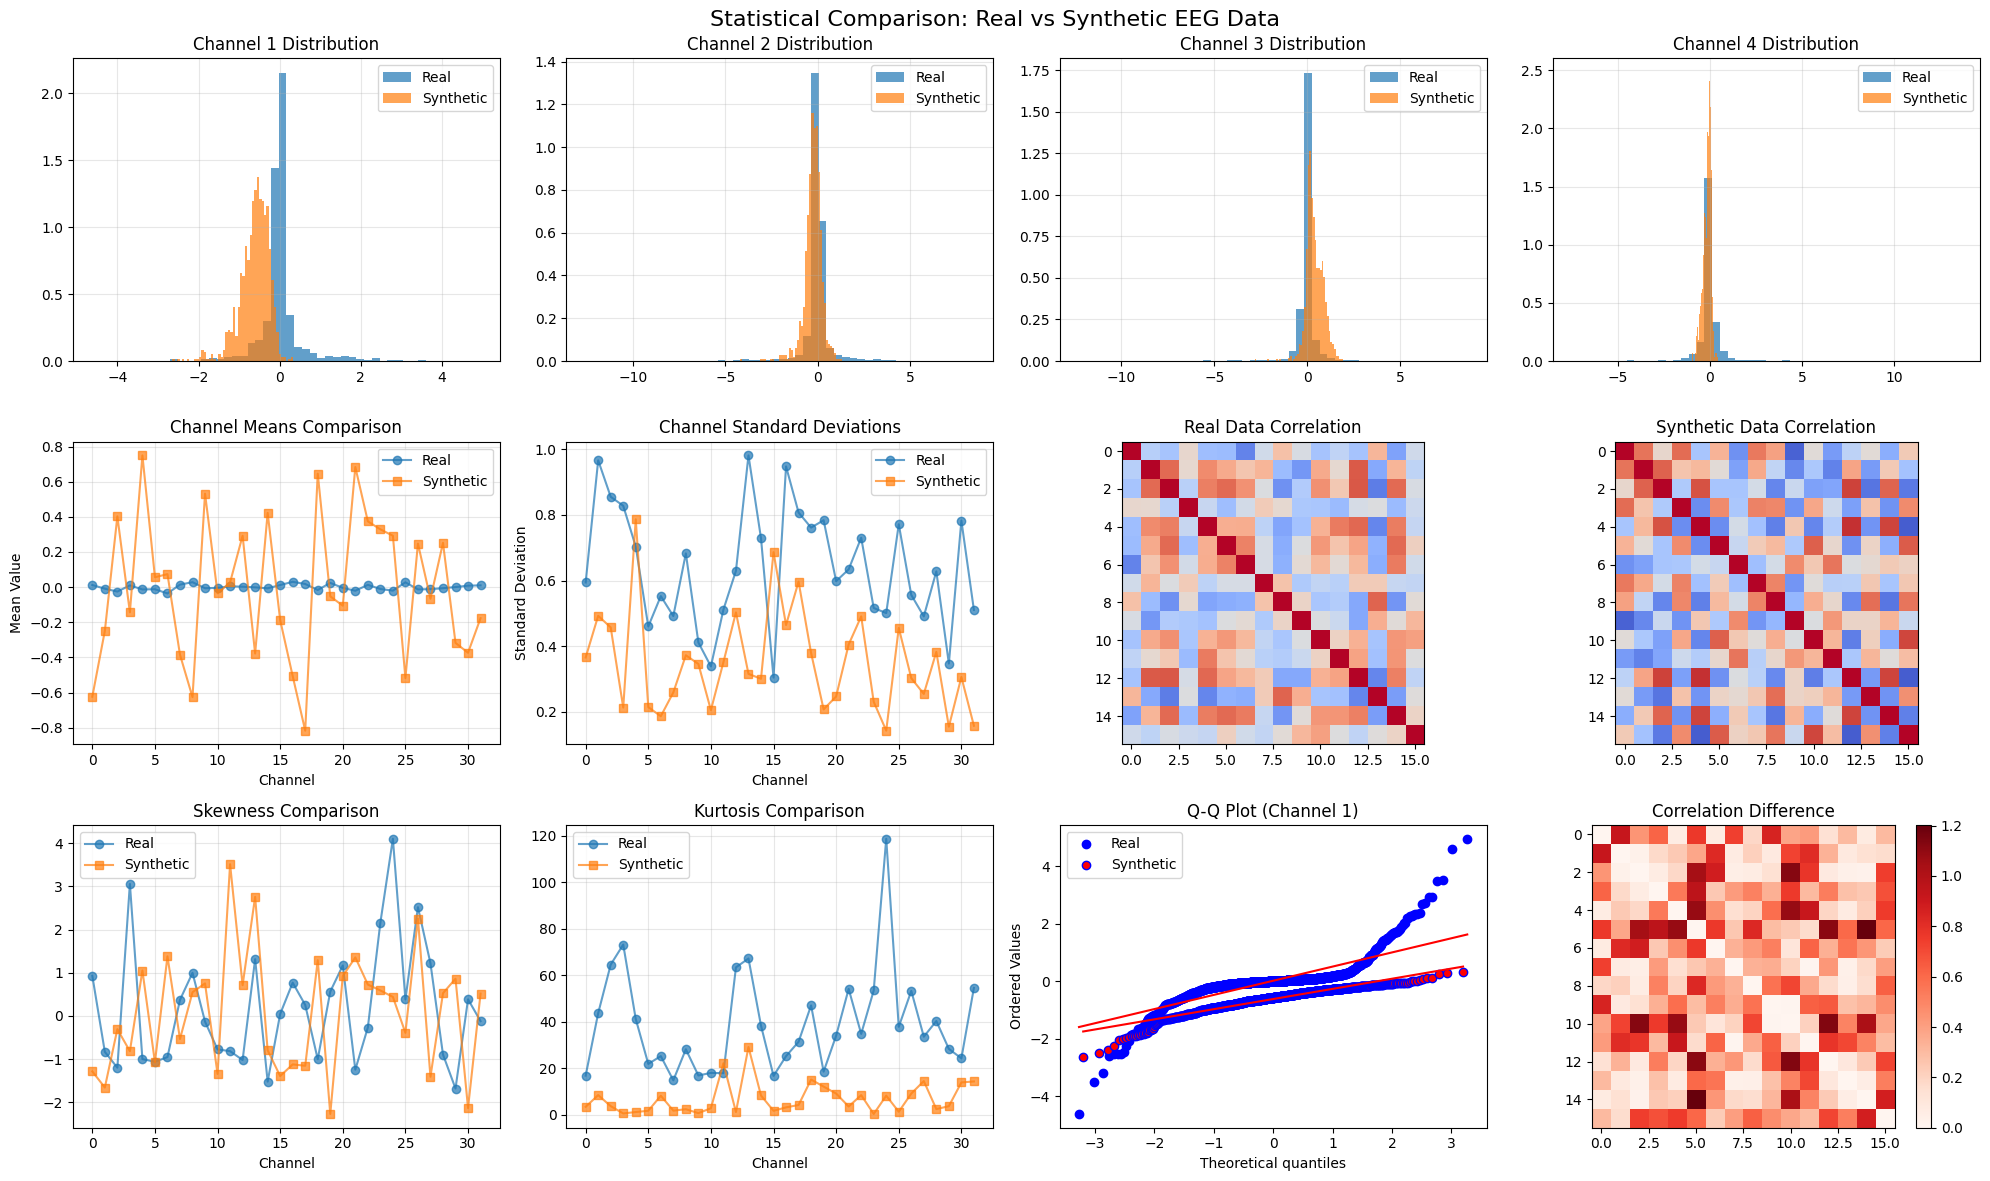

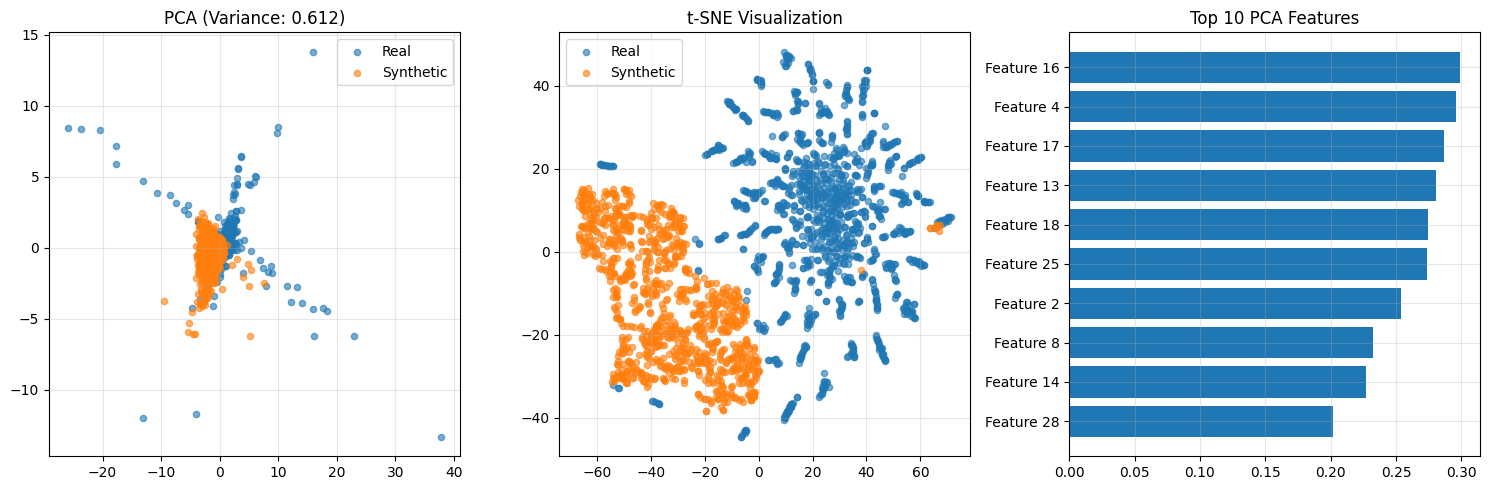

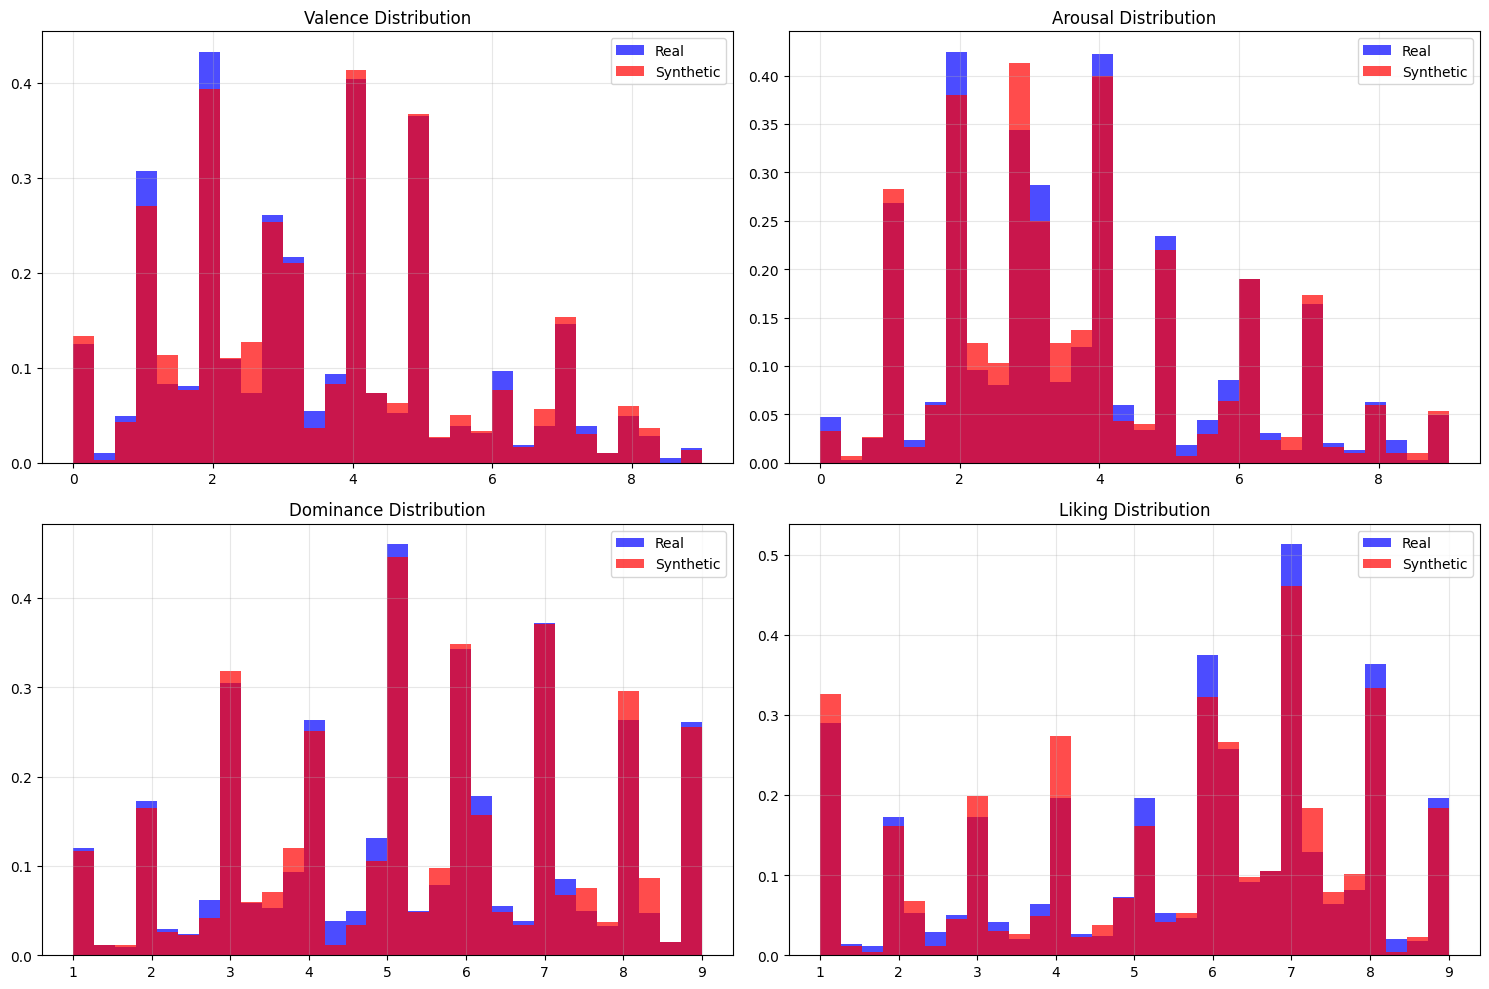

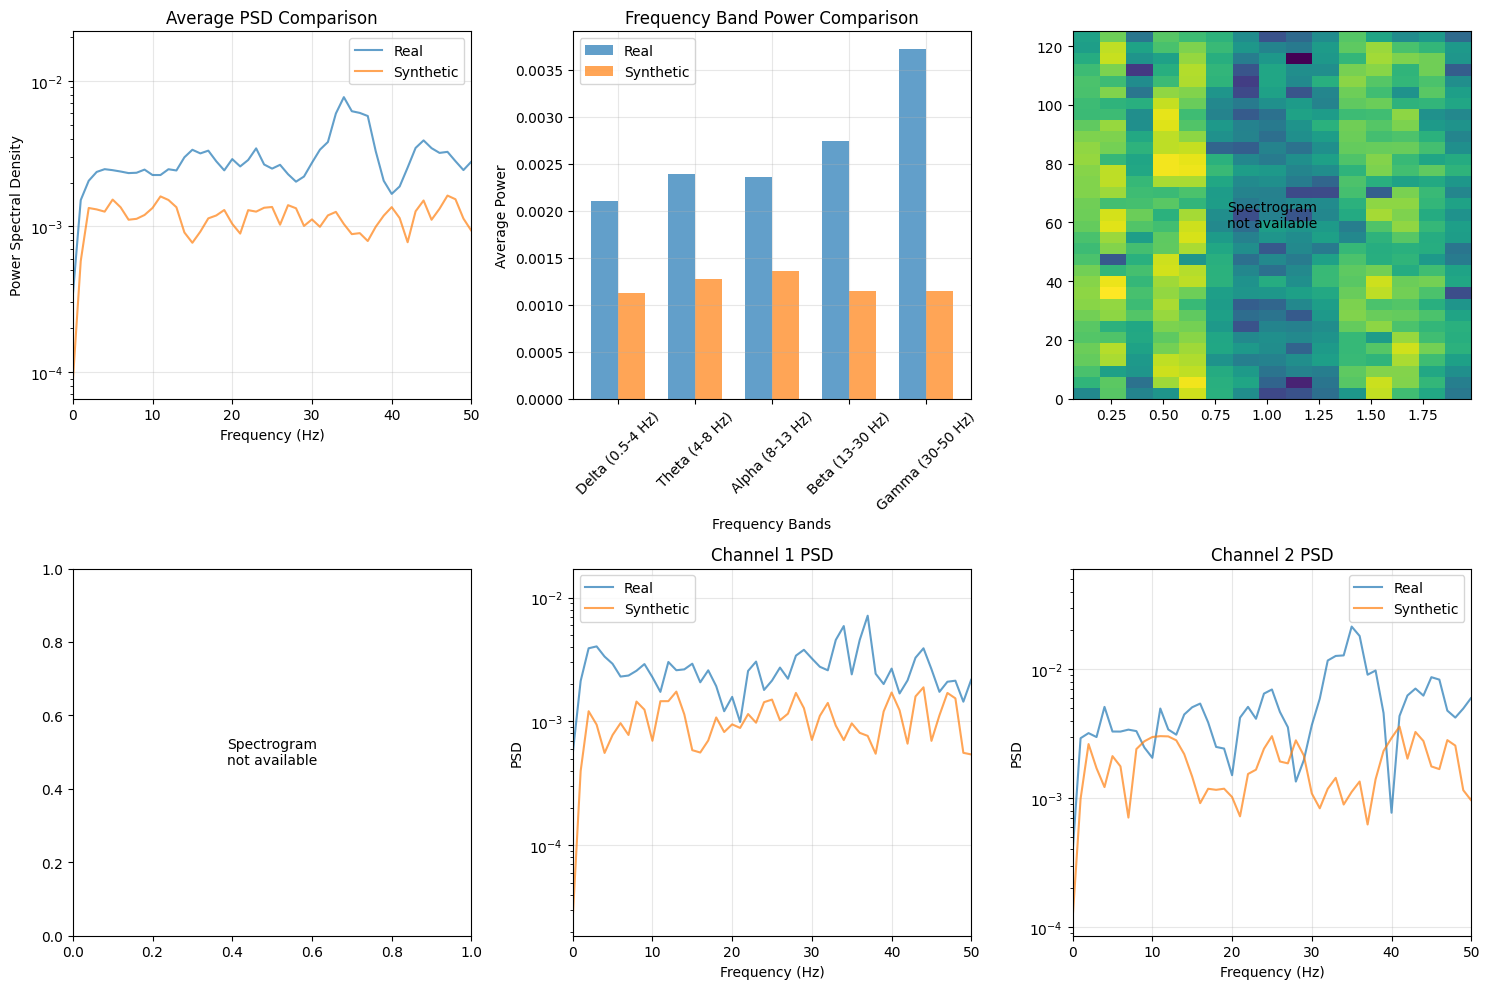

In [26]:
evaluator = EEGGANEvaluator(
    generator=G,
    real_data=torch.tensor(X, dtype=torch.float32),
    real_labels=torch.tensor(y, dtype=torch.float32),
    device='cuda:0'  # or 'cpu'
)

metrics, synthetic_data, synthetic_labels = evaluator.generate_evaluation_report(
    n_samples=1000, 
    save_plots=True
)